# **Installs and Imports**

In [77]:
import pandas as pd
import csv
from scipy import stats
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln # To compute log-factorial efficiently
import matplotlib.pyplot as plt

# **Prepare data**

In [78]:
def read_into_list(file_path):
    with open(file_path) as csvfile:
        reader = csv.reader(csvfile)
        read_values = [row for row in reader]
    return read_values
def convert_elements_to_float(lst):
    for i in range(len(lst)):
    # Access the first element of the inner list to get the actual value
        if lst[i] and lst[i][0].isdigit():
            lst[i] = int(lst[i][0]) # Convert the element to int
    return lst

In [79]:
ec012_187_res1 = read_into_list("./ec012ec.187.res.1")
ec012_187_res1 = convert_elements_to_float(ec012_187_res1)

ec012_375_res2 = read_into_list("./ec012ec.375.res.2")
ec012_375_res2 = convert_elements_to_float(ec012_375_res2)

ec016_674_res2 = read_into_list("./ec016.674.res.2")
ec016_674_res2 = convert_elements_to_float(ec016_674_res2)

# **Comparing poisson distribution with actual data**

In [80]:
class poisson_distribution:
    def __init__(self, samples_name, samples):
        self.samples_name = samples_name
        self.samples = np.array(samples, dtype=np.float64)
        self.mu = np.mean(samples) # Get avg
        self.sigma = np.std(samples, ddof=1)

    def poisson_neg_log_likelihood(self, params):
        # Poisson negative log-likelihood
        lambda_ = params[0]
        log_likelihood = -np.sum(self.samples * np.log(lambda_) - lambda_ - gammaln(self.samples+1))
        return log_likelihood

    def MLE(self):
        initParams = [10]
        results = minimize(self.poisson_neg_log_likelihood, initParams, method='Nelder-Mead')
        return results

    def print_results(self):
        results = self.MLE()
        print()
        print("DATA -", self.samples_name)
        print("mean*  = {:.3f} std*  = {:.3f}".format(results.x[0], np.sqrt(results.x[0])))
        print("mean   = {:.3f} std   = {:.3f}".format(self.mu, self.sigma))
        print("(mean* should be a good estimation to actual mean)")
        print("(if sample standard deviation (sd) is larger than possion estimated standard deviation (sd*), that means poisson's standard deviation is too small for actual sample data's standard deviation\nAKA, data does NOT follow poisson distribution)")

## **Possion calculations**

In [81]:
dataset1 = poisson_distribution("ec012_187_res1", ec012_187_res1)
dataset1.print_results()

dataset2 = poisson_distribution("ec012_375_res2", ec012_375_res2)
dataset2.print_results()

dataset3 = poisson_distribution("ec016_674_res2", ec016_674_res2)
dataset3.print_results()


DATA - ec012_187_res1
mean*  = 10608559.500 std*  = 3257.078
mean   = 10608558.758 std   = 6222835.129
(mean* should be a good estimation to actual mean)
(if sample standard deviation (sd) is larger than possion estimated standard deviation (sd*), that means poisson's standard deviation is too small for actual sample data's standard deviation
AKA, data does NOT follow poisson distribution)

DATA - ec012_375_res2
mean*  = 6294893.188 std*  = 2508.963
mean   = 6294893.082 std   = 3667389.666
(mean* should be a good estimation to actual mean)
(if sample standard deviation (sd) is larger than possion estimated standard deviation (sd*), that means poisson's standard deviation is too small for actual sample data's standard deviation
AKA, data does NOT follow poisson distribution)

DATA - ec016_674_res2
mean*  = 12947055.688 std*  = 3598.202
mean   = 12947055.175 std   = 8435671.208
(mean* should be a good estimation to actual mean)
(if sample standard deviation (sd) is larger than possion e

# **Fit poisson distribution with time intervals**

In [84]:
class plot_spikes():
    def __init__(self, spike_times, dataset_name):
        self.dataset_name = dataset_name
        self.spike_times = spike_times

    # Function to compute spike counts in different time bins
    def compute_fano_factor(self, bin_sizes):
        fano_factors = []

        for bin_size in bin_sizes:
            # Count spikes in each bin
            max_time = self.spike_times[-1]
            bins = np.arange(0, max_time, bin_size)
            spike_counts, _ = np.histogram(self.spike_times, bins=bins)

            # Compute mean and variance of spike counts
            mean_count = np.mean(spike_counts)
            var_count = np.var(spike_counts, ddof=1)  # Sample variance

            # Compute Fano Factor (variance / mean)
            fano_factor = var_count / mean_count if mean_count > 0 else np.nan
            fano_factors.append(fano_factor)

            print(f"Bin size {bin_size} ms: Mean={mean_count:.2f}, Variance={var_count:.2f}, Fano Factor={fano_factor:.2f}")

        return fano_factors

    # Function to check inter-spike intervals exponential fit
    def plot_isi_distribution(self):
        isi = np.diff(self.spike_times)  # Compute inter-spike intervals
        lambda_mle = 1 / np.mean(isi)  # MLE estimate for exponential rate

        # Histogram of ISI
        plt.figure(figsize=(8,5))
        plt.hist(isi, bins=30, density=True, alpha=0.6, label="Observed ISI")

        # Exponential PDF
        x = np.linspace(0, max(isi), 100)
        plt.plot(x, lambda_mle * np.exp(-lambda_mle * x), label="Exponential Fit", color='red')

        plt.xlabel("Inter-Spike Interval (ms)")
        plt.ylabel("Density")
        plt.legend()
        plt.title("ISI Distribution vs. Exponential Fit")
        plt.show()

        # KS test for goodness-of-fit
        ks_stat, p_value = stats.kstest(isi, 'expon', args=(0, 1/lambda_mle))
        print(f"KS Test for Exponential Fit: KS Statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
        if p_value < 0.05:
            print("ISI distribution significantly deviates from exponential (not Poisson).")
        else:
            print("ISI distribution is consistent with exponential (Poisson-like behavior).")
    def run_analysis(self):
        # Run the analysis
        bin_sizes = [10, 50, 100, 500]  # Different time bin sizes in ms
        fano_factors = self.compute_fano_factor(bin_sizes)
        self.plot_isi_distribution()
        print()
        print()


Bin size 10 ms: Mean=0.04, Variance=0.04, Fano Factor=0.96
Bin size 50 ms: Mean=0.20, Variance=0.17, Fano Factor=0.85
Bin size 100 ms: Mean=0.41, Variance=0.32, Fano Factor=0.79
Bin size 500 ms: Mean=2.03, Variance=1.85, Fano Factor=0.91


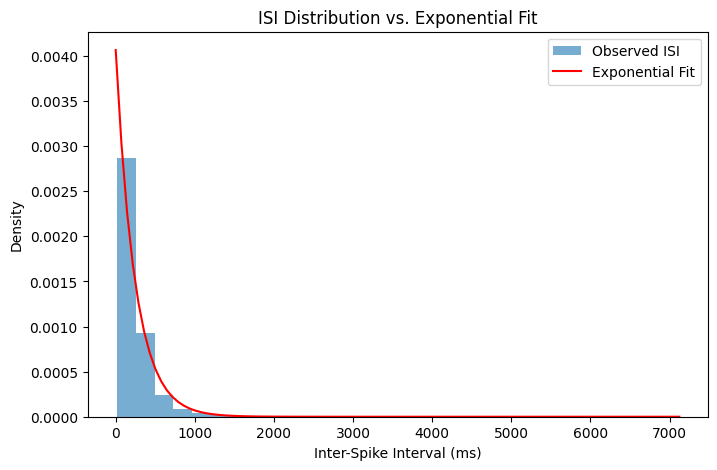

KS Test for Exponential Fit: KS Statistic = 0.1078, p-value = 0.0000
ISI distribution significantly deviates from exponential (not Poisson).


Bin size 10 ms: Mean=0.04, Variance=0.04, Fano Factor=0.96
Bin size 50 ms: Mean=0.21, Variance=0.19, Fano Factor=0.89
Bin size 100 ms: Mean=0.42, Variance=0.37, Fano Factor=0.89
Bin size 500 ms: Mean=2.10, Variance=2.07, Fano Factor=0.99


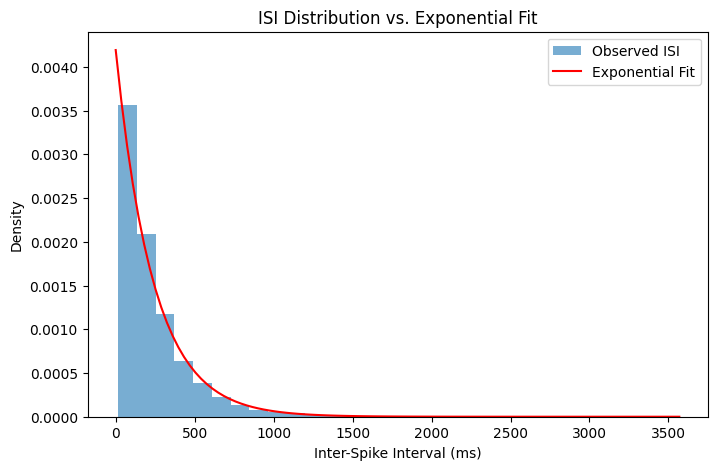

KS Test for Exponential Fit: KS Statistic = 0.0688, p-value = 0.0000
ISI distribution significantly deviates from exponential (not Poisson).


Bin size 10 ms: Mean=0.02, Variance=0.02, Fano Factor=0.98
Bin size 50 ms: Mean=0.10, Variance=0.10, Fano Factor=1.02
Bin size 100 ms: Mean=0.21, Variance=0.24, Fano Factor=1.15
Bin size 500 ms: Mean=1.03, Variance=2.21, Fano Factor=2.14


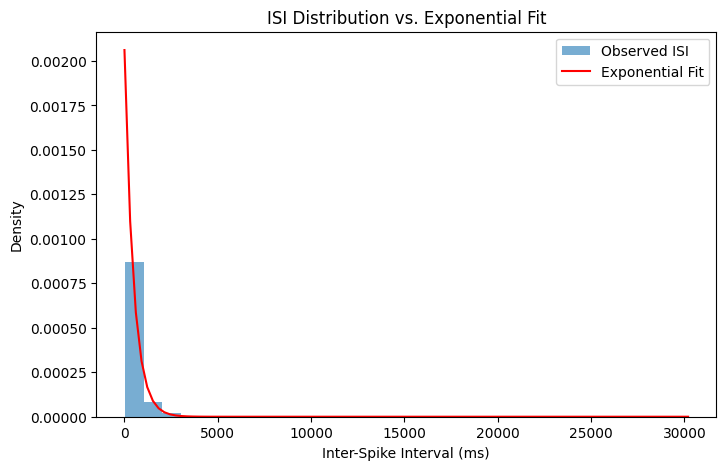

KS Test for Exponential Fit: KS Statistic = 0.1742, p-value = 0.0000
ISI distribution significantly deviates from exponential (not Poisson).




In [86]:
plot1 = plot_spikes(ec012_187_res1, "ec012_187_res1")
plot1.run_analysis()

plot2 = plot_spikes(ec012_375_res2, "ec012_375_res2")
plot2.run_analysis()

plot3 = plot_spikes(ec016_674_res2, "ec016_674_res2")
plot3.run_analysis()